# S3

**Customer Experience Analyst:**  
Is there a relationship between the price of accommodation and overall customer satisfaction?  
How does this relationship vary depending on the different cities where the accommodations are located?

In [772]:
# Import necessary libraries
import os
import warnings

# Data handling
import pandas as pd
import numpy as np

# Statistical analysis
from scipy import stats
from scipy.stats import (
    shapiro, ks_2samp, skew, kurtosis, kstest,
    ttest_ind, mannwhitneyu
)
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
warnings.filterwarnings("ignore")

In [802]:
sns.set_theme(
    style="white",         # Clean background
    context="talk",        # Larger labels for presentations
    palette="seismic"      # High-contrast color palette
)

plt.rcParams.update({
    "axes.titlesize": 18,         # Title font size
    "axes.labelsize": 14,         # Axis label font size
    "xtick.labelsize": 14,        # X-axis tick label size
    "ytick.labelsize": 14,        # Y-axis tick label size
    "figure.figsize": (8, 6),    # Default figure size
    "figure.dpi": 100,            # Figure resolution
    "axes.grid": False,           # No grid lines for a cleaner look
    "axes.spines.top": False,     # Remove top border
    "axes.spines.right": False    # Remove right border
})

## Data Loading

In [472]:
PATH = 'Data'
SPRINT = 3
filename = f'Tourist_Accommodation07042025.csv'

In [473]:
def read_file(filename):
    """
    Input: filename (string) - path to the .csv file.
    Function reads .csv data with specific date columns parsed.
    Output: DataFrame or error message.
    """
    try:
        # Reading the file and parsing dates
        df = pd.read_csv(os.path.join('..', PATH, filename), parse_dates=['insert_date', 'first_review_date', 'last_review_date'], dayfirst=True)
        display(df.head())        
        return df
    except Exception as error:
        print("An exception occurred:", error)
        return None

In [474]:
df = read_file(filename)

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,...,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date,standardized_city,standardized_neighbourhood,autonomous_community,has_reviews
0,11964,A ROOM WITH A VIEW,Private bedroom in our attic apartment. Right ...,45553,Centro,NaN,Private room,2,2.0,1.0,...,100.0,0,75.0,spain,malaga,2018-07-31,Málaga,Centro,Andalucía,True
1,21853,Bright and airy room,We have a quiet and sunny room with a good vie...,83531,C�rmenes,Latina,Private room,1,1.0,1.0,...,90.0,0,52.0,spain,madrid,2020-01-10,Madrid,Los Cármenes,Comunidad de Madrid,True
2,32347,Explore Cultural Sights from a Family-Friendly...,Open French doors and step onto a plant-filled...,139939,San Vicente,Casco Antiguo,Entire home/apt,4,1.0,2.0,...,100.0,1,142.0,spain,sevilla,2019-07-29,Sevilla,San Vicente,Andalucía,True
3,35379,Double 02 CasanovaRooms Barcelona,Room at a my apartment. Kitchen and 2 bathroom...,152232,l'Antiga Esquerra de l'Eixample,Eixample,Private room,2,2.0,1.0,...,90.0,1,306.0,spain,barcelona,2020-01-10,Barcelona,L'Antiga Esquerra de l'Eixample,Cataluña,True
4,35801,Can Torras Farmhouse Studio Suite,Lay in bed & watch sunlight change the mood of...,153805,Quart,NaN,Private room,5,1.0,2.0,...,100.0,0,39.0,spain,girona,2019-02-19,Girona,Quart,Cataluña,True


In [475]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9650 entries, 0 to 9649
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 9650 non-null   int64         
 1   name                         9647 non-null   object        
 2   description                  9516 non-null   object        
 3   host_id                      9650 non-null   int64         
 4   neighbourhood_name           9650 non-null   object        
 5   neighbourhood_district       5860 non-null   object        
 6   room_type                    9650 non-null   object        
 7   accommodates                 9650 non-null   int64         
 8   bathrooms                    9578 non-null   float64       
 9   bedrooms                     9580 non-null   float64       
 10  beds                         9605 non-null   float64       
 11  amenities_list               9634 non-null 

## Data Cleaning & Preparation

##### Goal: Filter only relevant listings with valid prices and review data

**Seleccionamos los aspectos a comparar**

In [479]:
review_columns = [
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value'
]
# Aspects to compare (excluding overall rating)
aspects = review_columns[1:]  
print(aspects)

review_columns_2 = ['review_scores_rating', 'review_scores_value']

['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']


In [480]:
print(df.isna().sum())

apartment_id                      0
name                              3
description                     134
host_id                           0
neighbourhood_name                0
neighbourhood_district         3790
room_type                         0
accommodates                      0
bathrooms                        72
bedrooms                         70
beds                             45
amenities_list                   16
price                           241
minimum_nights                    0
maximum_nights                    0
has_availability                  0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews                 0
first_review_date              2522
last_review_date               2523
review_scores_rating           2625
review_scores_accuracy         2634
review_scores_cleanliness      2628
review_scores_checkin          2639
review_scores_communication 

In [481]:
# Remove rows without price 
df_filtered = df[df['price'].notna()]

In [482]:
# Remove rows without reviews 
df_filtered=df_filtered[df_filtered['number_of_reviews'] != 0]

# Checking NaN values 
print(f"Missing values:\n{df_filtered[review_columns].isnull().sum()}")

Missing values:
review_scores_rating           105
review_scores_accuracy         114
review_scores_cleanliness      108
review_scores_checkin          119
review_scores_communication    110
review_scores_location         120
review_scores_value            120
dtype: int64


Preparación de datos  
**Filtramos solo alojamientos con reviews completas**

In [484]:
# Drop rows with NaN values in the selected review columns
df_filtered = df_filtered.dropna(subset=['review_scores_rating', 'review_scores_accuracy', 
                             'review_scores_cleanliness', 'review_scores_checkin',
                             'review_scores_communication', 'review_scores_location',
                             'review_scores_value'])

# Checking NaN values 
print(f"Missing values:\n{df_filtered[review_columns].isnull().sum()}")

Missing values:
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
dtype: int64


In [485]:
print(df_filtered.isna().sum())

apartment_id                      0
name                              0
description                      53
host_id                           0
neighbourhood_name                0
neighbourhood_district         2376
room_type                         0
accommodates                      0
bathrooms                        42
bedrooms                         52
beds                              5
amenities_list                    8
price                             0
minimum_nights                    0
maximum_nights                    0
has_availability                  0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews                 0
first_review_date                 0
last_review_date                  2
review_scores_rating              0
review_scores_accuracy            0
review_scores_cleanliness         0
review_scores_checkin             0
review_scores_communication 

In [486]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6899 entries, 0 to 9643
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 6899 non-null   int64         
 1   name                         6899 non-null   object        
 2   description                  6846 non-null   object        
 3   host_id                      6899 non-null   int64         
 4   neighbourhood_name           6899 non-null   object        
 5   neighbourhood_district       4523 non-null   object        
 6   room_type                    6899 non-null   object        
 7   accommodates                 6899 non-null   int64         
 8   bathrooms                    6857 non-null   float64       
 9   bedrooms                     6847 non-null   float64       
 10  beds                         6894 non-null   float64       
 11  amenities_list               6891 non-null   obj

In [487]:
print(df_filtered.columns)

Index(['apartment_id', 'name', 'description', 'host_id', 'neighbourhood_name',
       'neighbourhood_district', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'amenities_list', 'price', 'minimum_nights',
       'maximum_nights', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'first_review_date', 'last_review_date',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'is_instant_bookable', 'reviews_per_month',
       'country', 'city', 'insert_date', 'standardized_city',
       'standardized_neighbourhood', 'autonomous_community', 'has_reviews'],
      dtype='object')


In [488]:
print(df_filtered.describe())

       apartment_id       host_id  accommodates    bathrooms     bedrooms  \
count  6.899000e+03  6.899000e+03   6899.000000  6857.000000  6847.000000   
mean   1.880398e+07  7.962578e+07      4.077258     1.500219     1.818315   
min    1.196400e+04  1.070400e+04      1.000000     0.000000     0.000000   
25%    1.077853e+07  1.186954e+07      2.000000     1.000000     1.000000   
50%    1.867098e+07  5.004197e+07      4.000000     1.000000     1.000000   
75%    2.605448e+07  1.266724e+08      6.000000     2.000000     2.000000   
max    4.735728e+07  3.768526e+08     16.000000    10.000000     9.000000   
std    1.098607e+07  8.048205e+07      2.378866     0.820380     1.148230   

              beds         price  minimum_nights  maximum_nights  \
count  6894.000000   6899.000000     6899.000000     6899.000000   
mean      2.751233    931.689230        4.179881      742.635599   
min       0.000000     80.000000        1.000000        1.000000   
25%       1.000000    440.000000  

## EDA

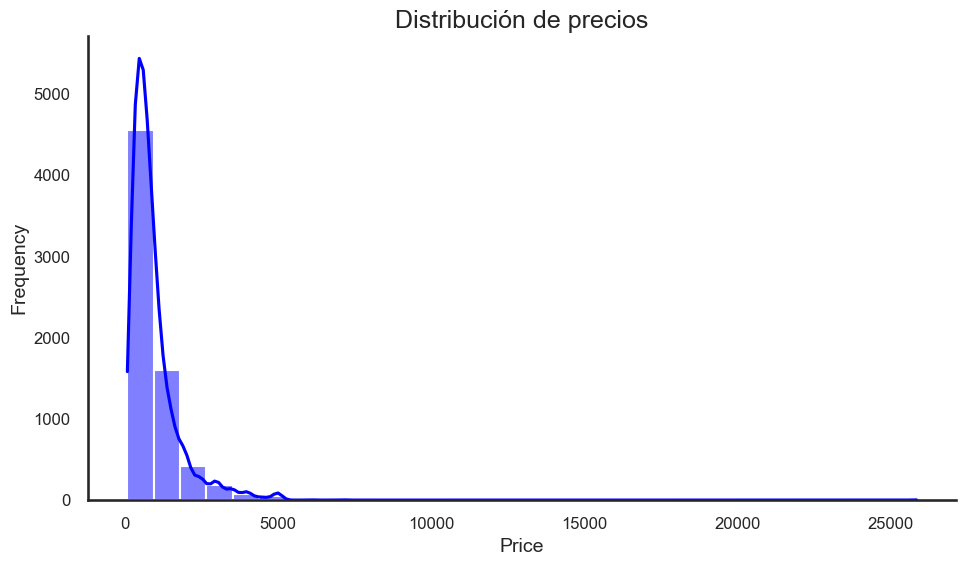

In [491]:
sns.histplot(df_filtered['price'], bins=30, kde=True, color='blue')
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title(f"Distribución de precios")
plt.tight_layout()
plt.show()

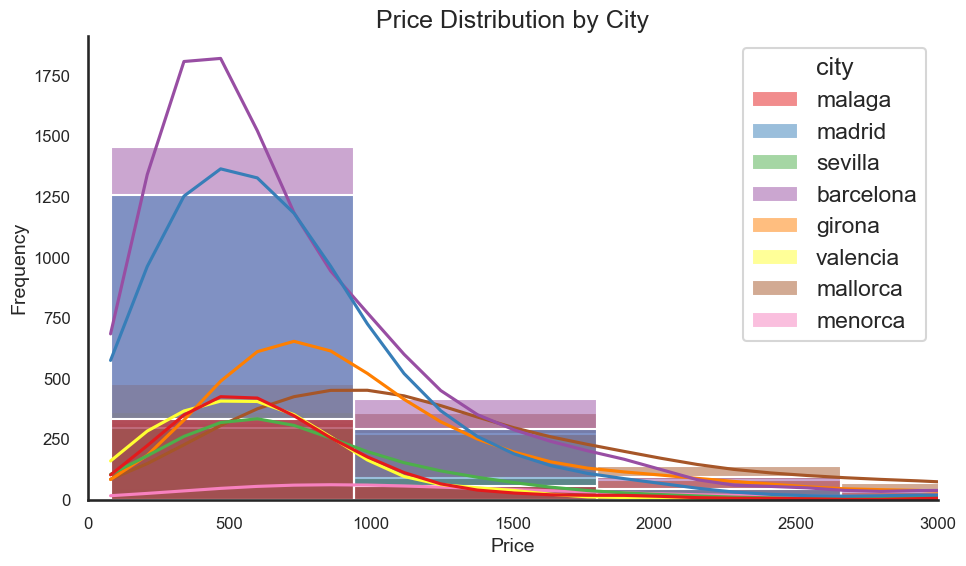

In [492]:
sorted_cities = sorted(df_filtered['city'].unique())
palette = sns.color_palette("Set1", n_colors=len(sorted_cities))

sns.histplot(df_filtered, x='price', bins=30, hue='city', kde=True, palette=palette)
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title(f"Price Distribution by City")
plt.xlim(0, 3000)
plt.tight_layout()
plt.show()

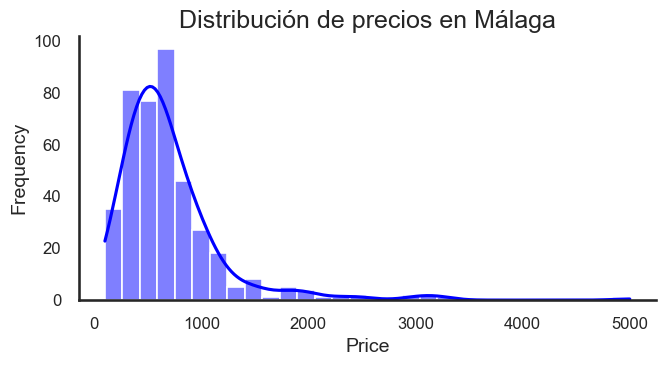

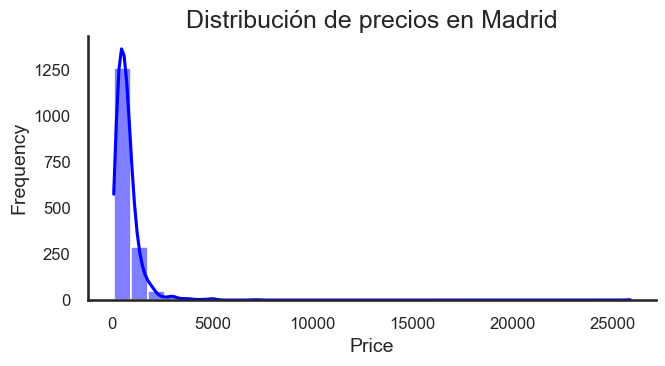

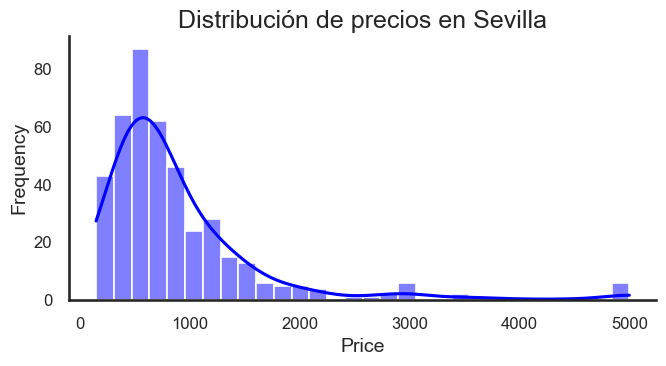

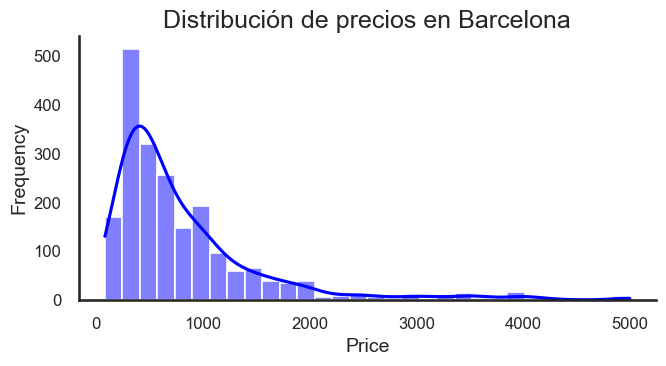

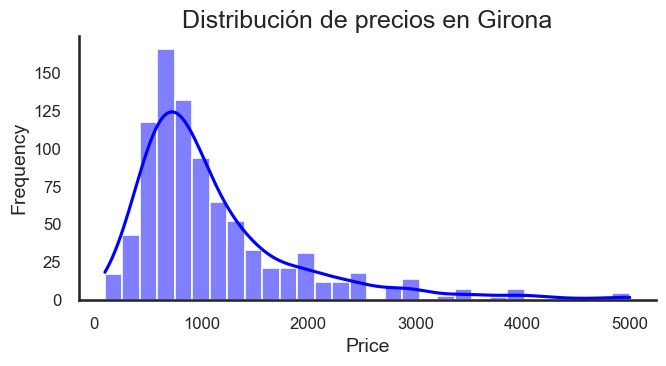

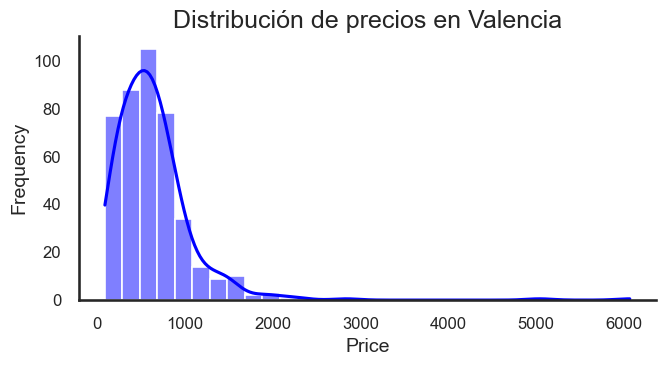

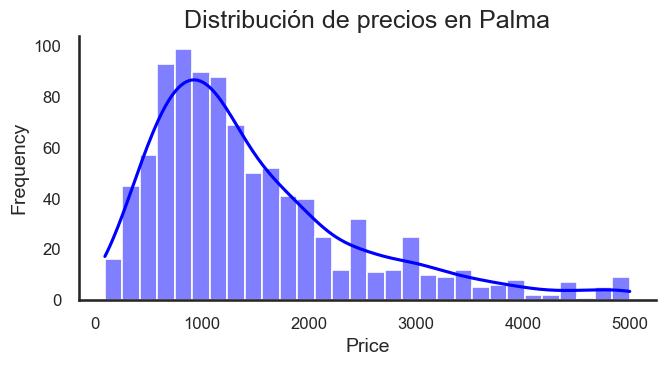

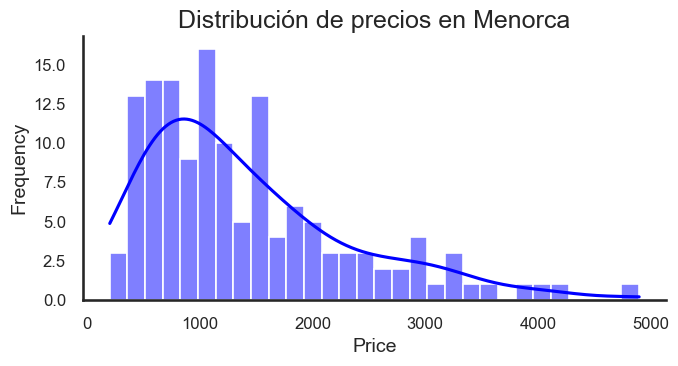

In [493]:
### Distribución de `price` por ciudad ###
cities = df_filtered['standardized_city'].unique()

for city in cities:
    plt.figure(figsize=(7, 4))
    city_data = df_filtered[df_filtered['standardized_city'] == city]
    
    sns.histplot(city_data['price'], bins=30, kde=True, color='blue')
    plt.xlabel("Price")
    plt.ylabel("Frequency")
    #plt.xlim(0, 5000)
    plt.title(f"Distribución de precios en {city}")
    plt.tight_layout()
    plt.show()


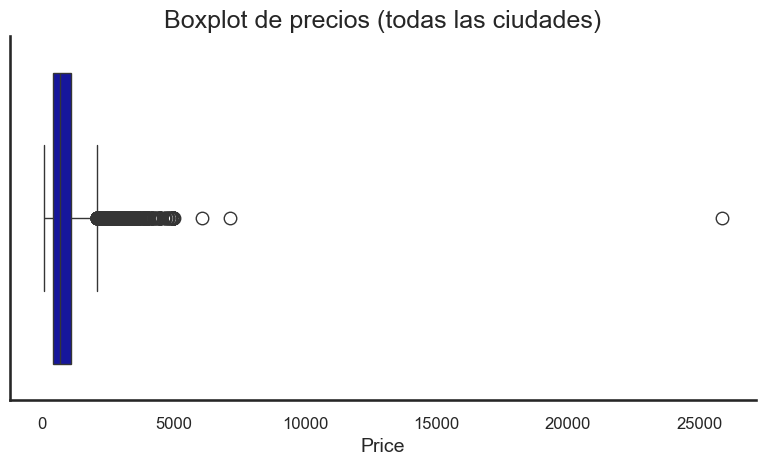

In [494]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_filtered['price'])
plt.xlabel("Price")
plt.title("Boxplot de precios (todas las ciudades)")
plt.tight_layout()
plt.show()

In [495]:
top5 = df_filtered.sort_values(by='price', ascending=False).head(5)

top5 = top5[['apartment_id', 'name', 'description', 'host_id', 'room_type', 'accommodates',
             'bathrooms', 'bedrooms', 'beds', 'amenities_list', 'price', 'standardized_city',
             'standardized_neighbourhood', 'autonomous_community', 'has_reviews']]

print(top5)


      apartment_id                                               name  \
8658      37153661  Unique Luxury Apartment 6People Pool & Facilities   
8928      39350327  2 habitaciones y Ba�o privado en Barrio Salamanca   
2294      12970898                     APARTAMENTO CENTRICO-EL CARMEN   
4308      19176730   Bello apartamento con terraza centro /Aire Acon.   
398        1351195                 Tossa de Mar Tourist Accommodation   

                                            description   host_id  \
8658  250 square meters - Exclusive luxury apartment...  42407188   
8928  Brand new floor (daylight basement) with 2 roo...  13669384   
2294  Apartamento totalmente reformado en 2018. Dos ...  71363084   
4308  Apartamento grande con capacidad para 5 person...  37406182   
398   Eighteenth century farmhouse in the heart of C...   7332030   

            room_type  accommodates  bathrooms  bedrooms  beds  \
8658  Entire home/apt             6        5.0       5.0   5.0   
8928     Priva

In [496]:
result = df_filtered[df_filtered['neighbourhood_name'] == 'Mirasierra'].sort_values(by='price', ascending=False)
result = result[['apartment_id', 'name', 'description', 'host_id', 'room_type', 'accommodates',
                 'bathrooms', 'bedrooms', 'beds', 'amenities_list', 'price', 'standardized_city',
                 'standardized_neighbourhood', 'autonomous_community', 'has_reviews']]

print(result)

      apartment_id                                               name  \
8658      37153661  Unique Luxury Apartment 6People Pool & Facilities   
2673      14078662                   Casa para 7 con piscina y padel!   
7545      31716236  Habitaci�n doble con piscina,ba�o privado y ga...   

                                            description    host_id  \
8658  250 square meters - Exclusive luxury apartment...   42407188   
2673  Casa para 7 personas, en frente del metro Paco...    6368114   
7545  Piso muy luminoso, zona tranquila y muy bonita...  226724936   

            room_type  accommodates  bathrooms  bedrooms  beds  \
8658  Entire home/apt             6        5.0       5.0   5.0   
2673  Entire home/apt             7        3.0       4.0   7.0   
7545     Private room             2        2.0       1.0   2.0   

                                         amenities_list    price  \
8658  Iron, Coffee maker, Fire extinguisher, Wifi, T...  25857.0   
2673  TV,Internet,Wifi,Ai

In [497]:
# Change 'price' for apartment_id == 37153661, divide by 10
df_filtered.loc[df_filtered['apartment_id'] == 37153661, 'price'] = df_filtered.loc[df_filtered['apartment_id'] == 37153661, 'price'] / 10
updated_record = df_filtered[df_filtered['apartment_id'] == 37153661]
print(updated_record[['apartment_id', 'name', 'price', 'room_type', 'accommodates']])

      apartment_id                                               name   price  \
8658      37153661  Unique Luxury Apartment 6People Pool & Facilities  2585.7   

            room_type  accommodates  
8658  Entire home/apt             6  


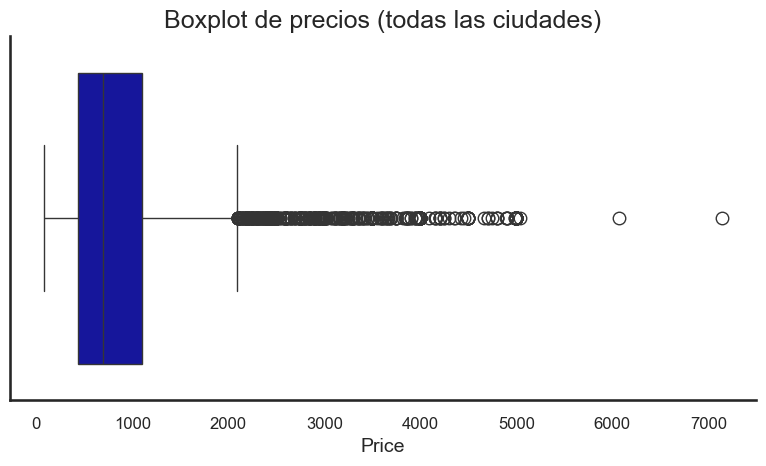

In [498]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_filtered['price'])
plt.xlabel("Price")
plt.title("Boxplot de precios (todas las ciudades)")
plt.tight_layout()
plt.show()

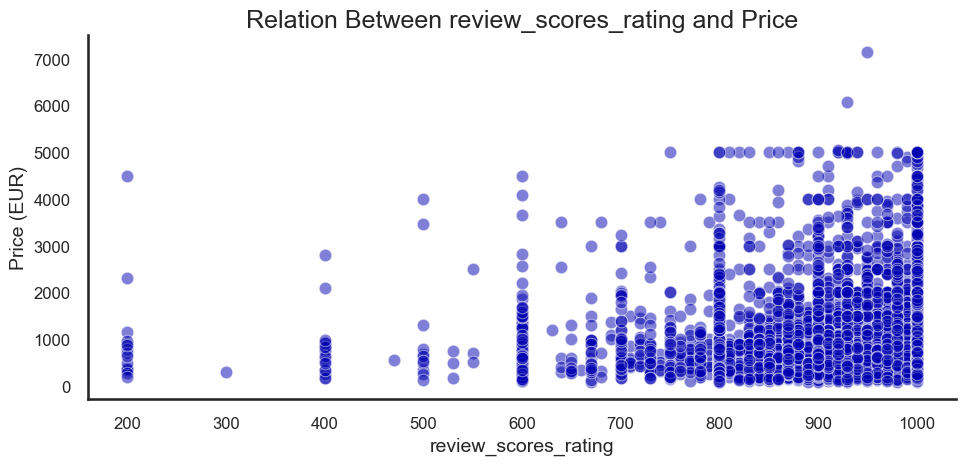

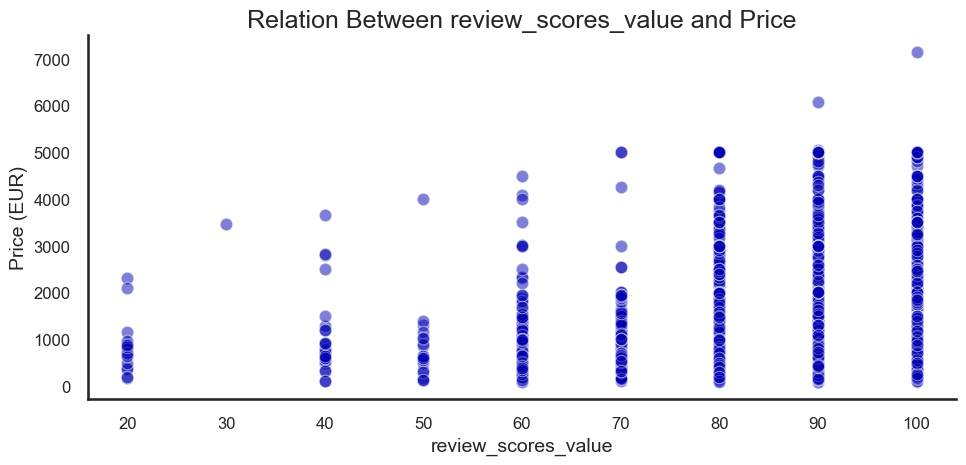

In [766]:
for column in review_columns_2:
    plt.figure(figsize=(10, 5))  
    sns.scatterplot(x=column, y='price', data=df_filtered, alpha=0.5)
    plt.title(f"Relation Between {column} and Price")
    plt.xlabel(column)
    plt.ylabel("Price (EUR)")
    plt.tight_layout()  
    plt.show()

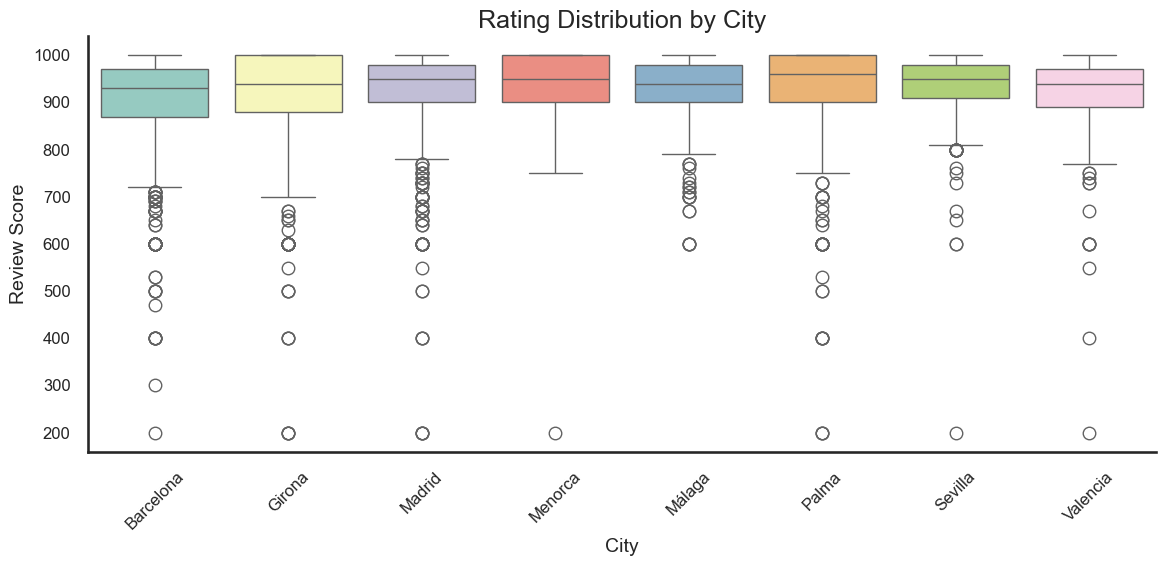

In [500]:
sorted_cities = sorted(df_filtered['standardized_city'].unique())

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_filtered,
    x='standardized_city',
    y='review_scores_rating',
    order=sorted_cities,
    palette='Set3'
)
plt.title('Rating Distribution by City')
plt.xlabel('City')
plt.ylabel('Review Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Analysis

Analysis Steps:


### 1. Price Normalization and Segmentation

Normalize price based on number of guests to enable fair comparisons

In [505]:
# Add per-person pricing and segments
df_filtered['price_per_person'] = df_filtered['price'] / df_filtered['accommodates']

In [893]:
df_filtered['price_per_person'].describe()

count    6899.000000
mean      240.716909
std       181.750564
min         9.375000
25%       148.000000
50%       200.000000
75%       287.500000
max      5000.000000
Name: price_per_person, dtype: float64

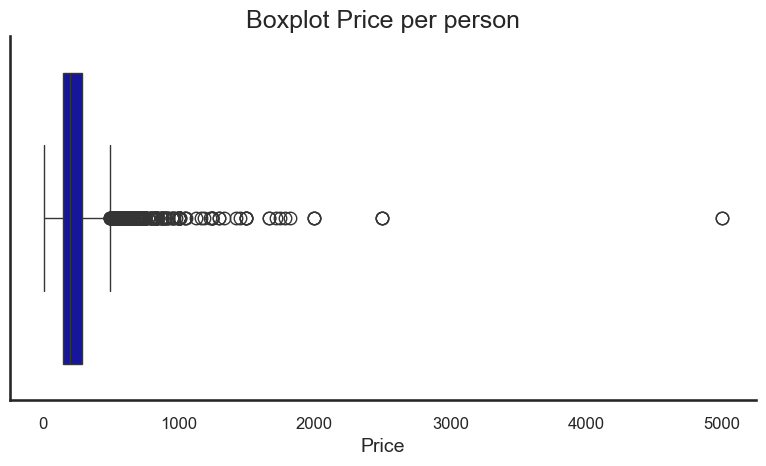

In [790]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_filtered['price_per_person'])
plt.xlabel("Price")
plt.title("Boxplot Price per person")
plt.tight_layout()
plt.show()

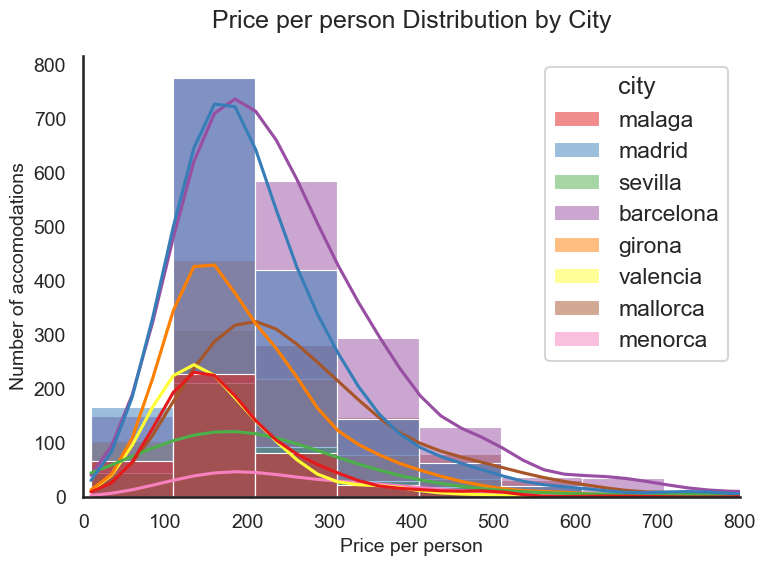

KS test statistic = 0.0480, p-value = 0.0000


In [806]:
sorted_cities = sorted(df_filtered['city'].unique())
palette = sns.color_palette("Set1", n_colors=len(sorted_cities))

sns.histplot(df_filtered, x='price_per_person', bins=50, hue='city', kde=True, palette=palette)
plt.xlabel("Price per person")
plt.ylabel("Number of accomodations")
plt.title(f"Price per person Distribution by City", pad=20)
plt.xlim(0, 800)
plt.tight_layout()
plt.show()


sample = df_filtered['price_per_person'].dropna()
sample = np.log1p(sample)
stat, p = kstest(sample, 'norm', args=(sample.mean(), sample.std()))
print(f"KS test statistic = {stat:.4f}, p-value = {p:.4f}")


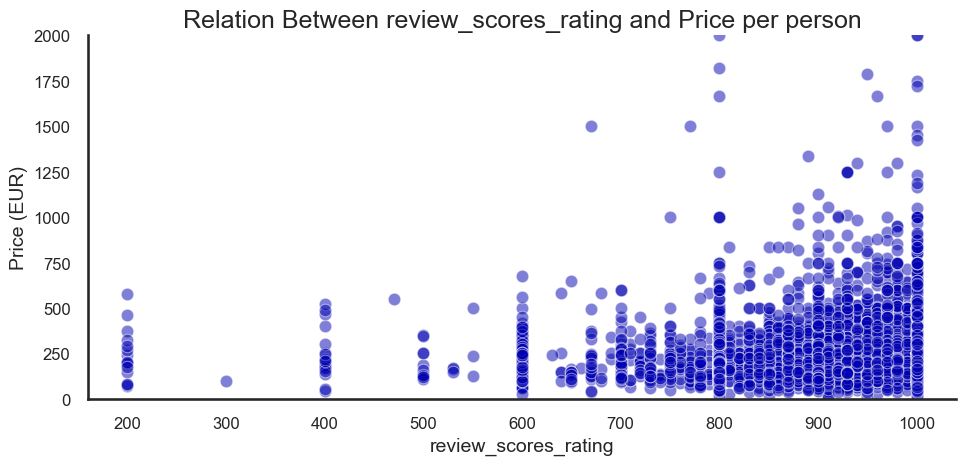

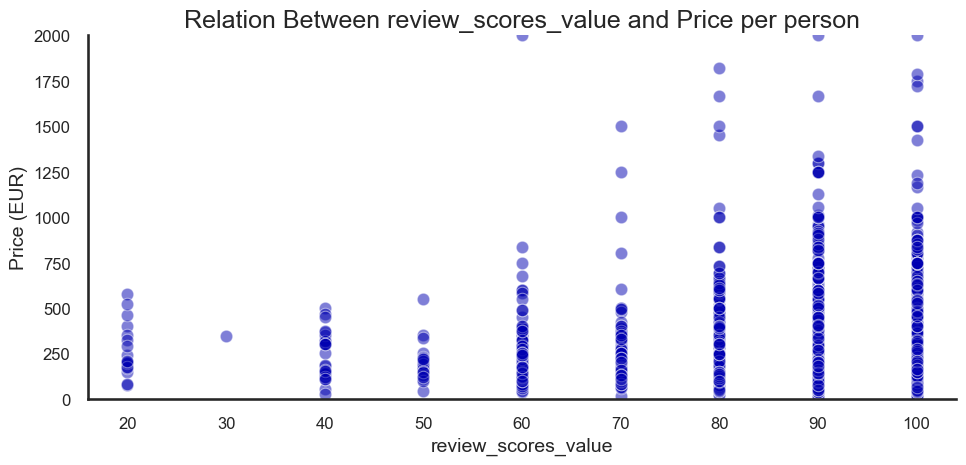

In [768]:
for column in review_columns_2:
    plt.figure(figsize=(10, 5))  
    sns.scatterplot(x=column, y='price_per_person', data=df_filtered, alpha=0.5)
    plt.title(f"Relation Between {column} and Price per person")
    plt.xlabel(column)
    plt.ylabel("Price (EUR)")
    plt.ylim(0, 2000)
    plt.tight_layout()  
    plt.show()

Categorization ´price_per_person´:

Budget: If the price per person is less than or equal to the 20th percentile, it is classified as "Budget" (the lowest 20% of prices in the city).

Mid-range: If the price is between the 20th percentile and the median, it is classified as "Mid-range". This represents the mid-range prices that are above the 20th percentile but below the median.

Premium: If the price is between the median and the 80th percentile, it is classified as "Premium", representing prices above the median but not yet in the top 20% of the city.

Luxury: If the price is above the 80th percentile, it is classified as "Luxury", representing the highest 20% of prices in the city.

In [510]:
def price_segments(row):
    # Filter data for each city to calculate the percentiles and median
    city_data = df_filtered[df_filtered['city'] == row['city']]
    
    # Calculate the median, 20th percentile, and 80th percentile for the city
    median = city_data['price_per_person'].median()
    percentile_20 = city_data['price_per_person'].quantile(0.2)
    percentile_80 = city_data['price_per_person'].quantile(0.8)
    
    # Categorize based on the price ranges
    if row['price_per_person'] <= percentile_20:
        return 'Budget'  # Price below the 20th percentile
    elif row['price_per_person'] <= median:
        return 'Mid-range'  # Price below the median, but above the 20th percentile
    elif row['price_per_person'] <= percentile_80:
        return 'Premium'  # Price between the median and 80th percentile
    else:
        return 'Luxury'  # Price above the 80th percentile

# Apply the function to the dataset
df_filtered['city_price_segment'] = df_filtered.apply(price_segments, axis=1)


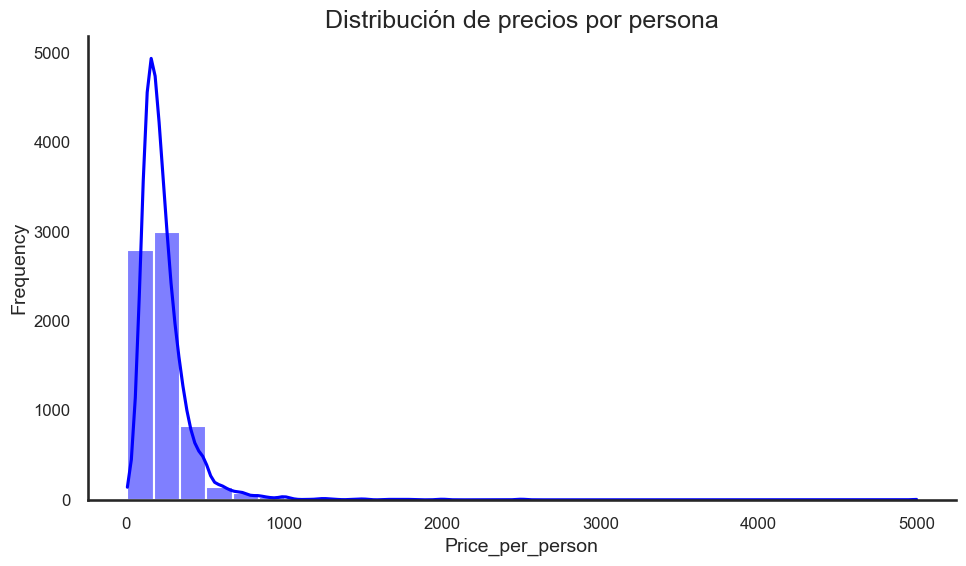

In [511]:
sns.histplot(df_filtered['price_per_person'], bins=30, kde=True, color='blue')
plt.xlabel("Price_per_person")
plt.ylabel("Frequency")
plt.title(f"Distribución de precios por persona")
#plt.xlim(0, 1000)
plt.tight_layout()
plt.show()

### 2. Rating Distribution by Price Segment

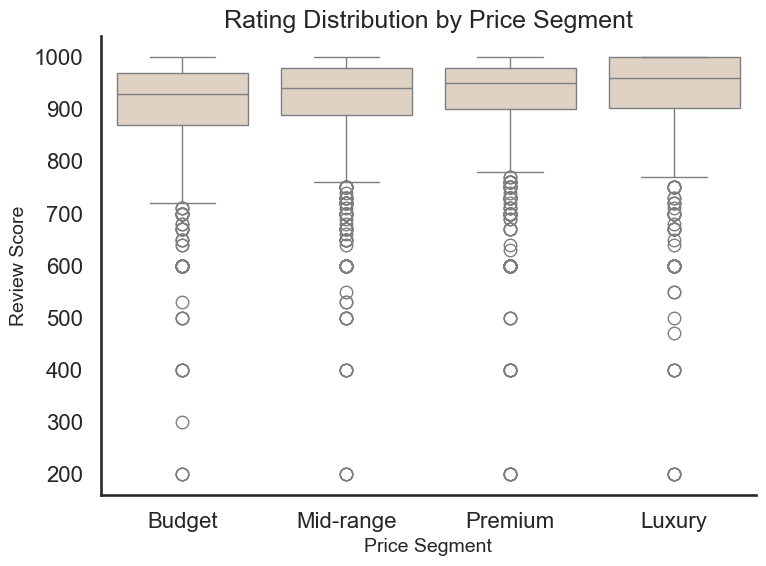

In [869]:

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df_filtered,
    x='city_price_segment',
    y='review_scores_rating',
    order=['Budget', 'Mid-range', 'Premium', 'Luxury'], color='#e4d2bf'
)

plt.title('Rating Distribution by Price Segment')
plt.xlabel('Price Segment')
plt.ylabel('Review Score')

# Set tick label sizes
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.show()


### 3. Rating Distribution by Price Segment by City

#### 1. Box-plot

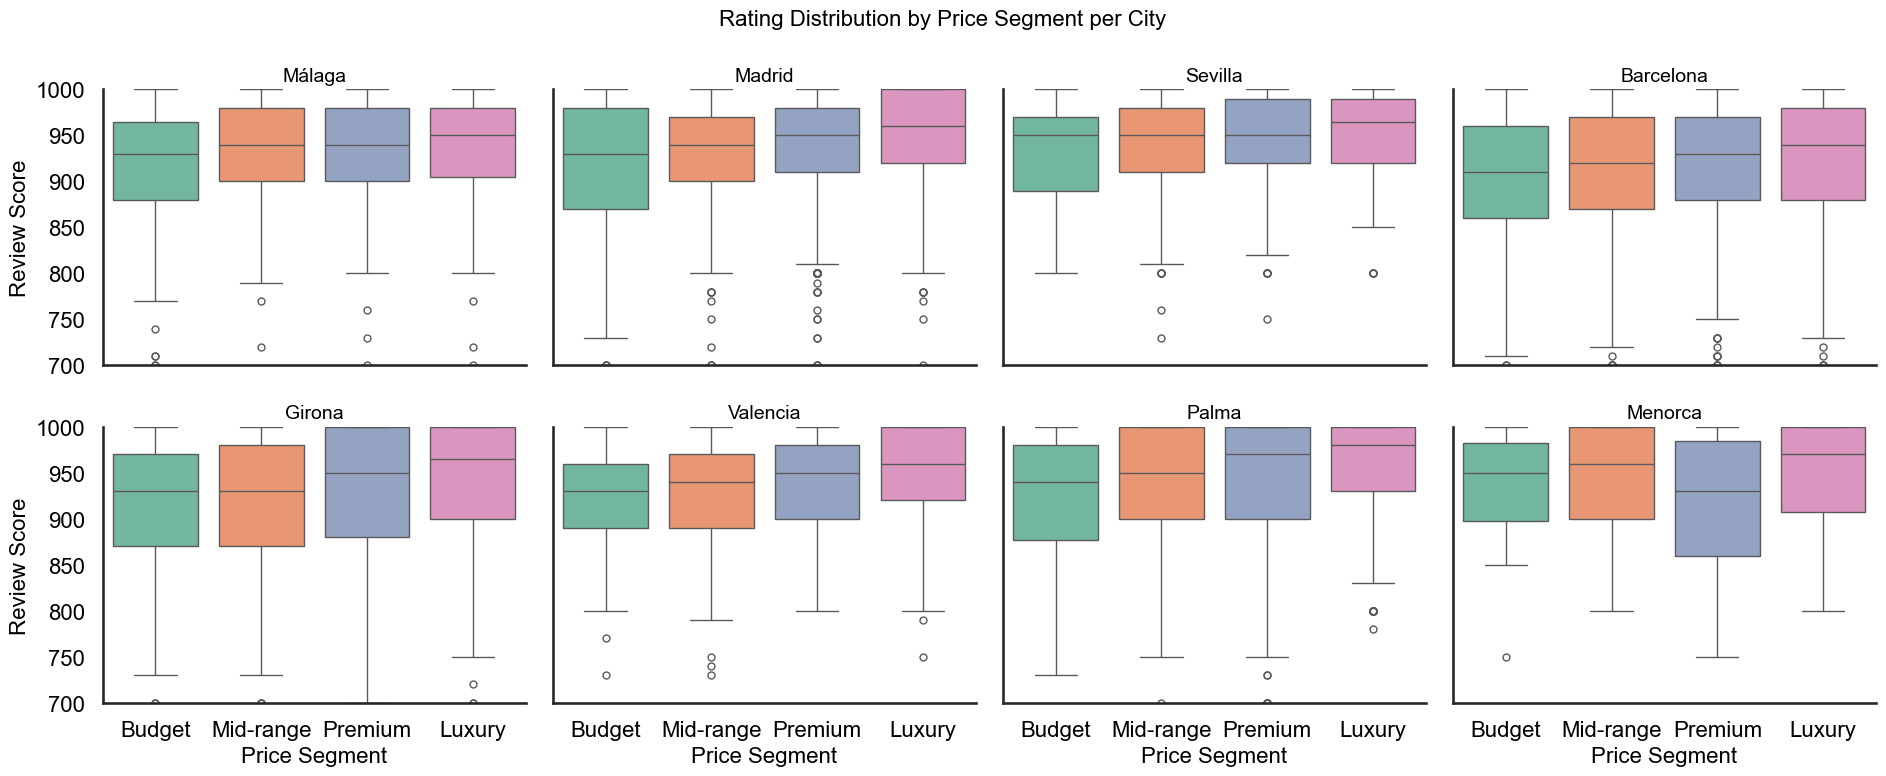

In [839]:
segment_order = ['Budget', 'Mid-range', 'Premium', 'Luxury']
sorted_cities = sorted(df_filtered['standardized_city'].unique())

g = sns.catplot(
    data=df_filtered,
    x='city_price_segment',
    y='review_scores_rating',
    col='standardized_city',
    kind='box',
    order=segment_order,
    col_wrap=4,
    height=4,
    aspect=1.2,
    palette='Set2',
    whis=1.5  
)

g.set(ylim=(700, 1000))

g.set_titles("{col_name}", fontsize=16, color='black')

g.set_axis_labels("Price Segment", "Review Score")
g.set_xlabels("Price Segment", fontsize=16, color='black')
g.set_ylabels("Review Score", fontsize=16, color='black')

for ax in g.axes.flatten():
    ax.tick_params(axis='both', labelsize=16, colors='black')

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Rating Distribution by Price Segment per City", fontsize=16, color='black')

plt.tight_layout()
plt.show()


#### 2. Average Score by City and Price Segment

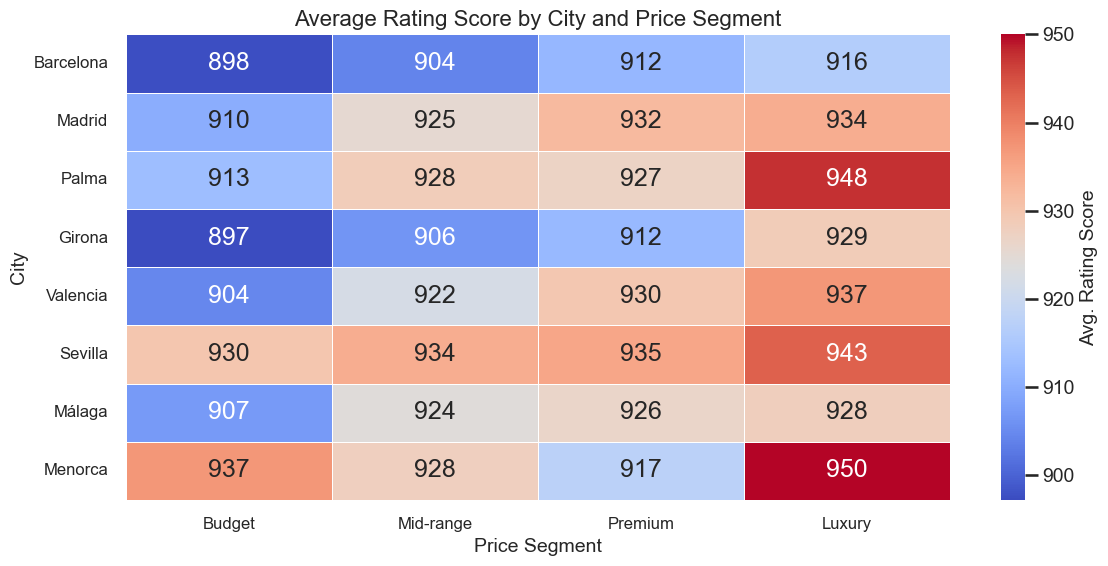

In [891]:
segment_order = ['Budget', 'Mid-range', 'Premium', 'Luxury']
manual_order = ['Barcelona', 'Madrid', 'Palma', 'Girona', 'Valencia', 'Sevilla', 'Málaga', 'Menorca']

# Calculate average rating by city and price segment
value_by_city_segment = df_filtered.groupby(['standardized_city', 'city_price_segment'])['review_scores_rating'].mean().unstack()

# Reorder both columns (segments) and index (cities)
value_by_city_segment = value_by_city_segment.loc[manual_order, segment_order]

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    value_by_city_segment,
    annot=True,
    fmt=".0f",
    cmap='coolwarm',
    linewidths=0.5,
    cbar_kws={'label': 'Avg. Rating Score'}
)
plt.title('Average Rating Score by City and Price Segment', fontsize=16)
plt.xlabel('Price Segment', fontsize=14)
plt.ylabel('City', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


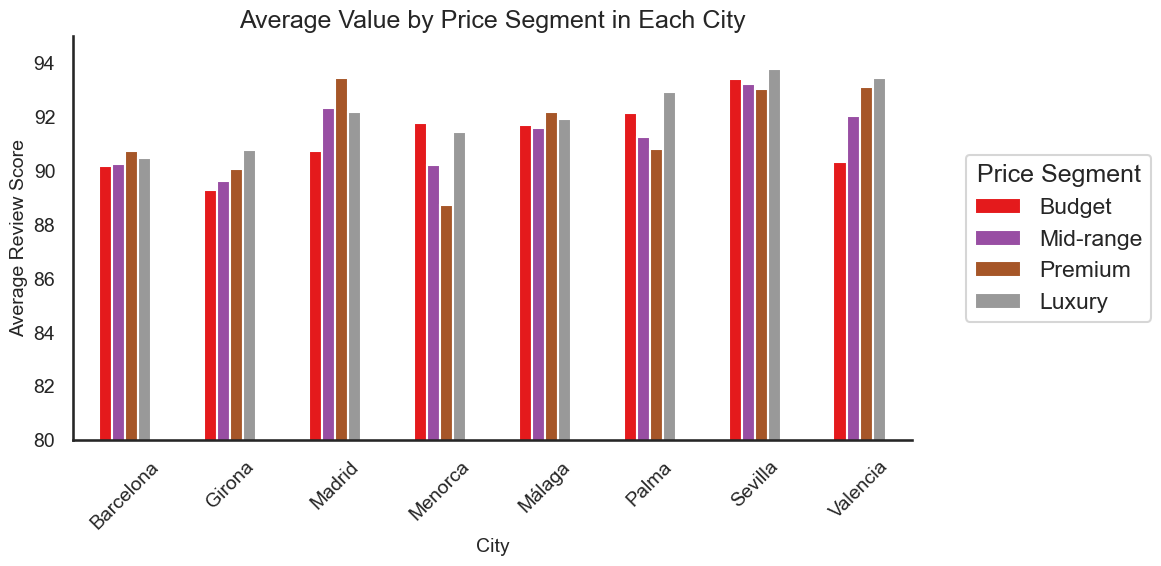

In [879]:
df_filtered_reset = df_filtered.reset_index(drop=True)

avg_rating = df_filtered_reset.groupby(['standardized_city', 'city_price_segment'])['review_scores_value'].mean().unstack()

segment_order = ['Budget', 'Mid-range', 'Premium', 'Luxury']
avg_rating = avg_rating[segment_order]

avg_rating.plot(kind='bar', figsize=(12, 6), colormap='Set1')
plt.title('Average Value by Price Segment in Each City')
plt.ylabel('Average Review Score')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.ylim(80, 95)

plt.legend(title='Price Segment', bbox_to_anchor=(1.05, 0.5), loc='center left')  # Легенда справа
plt.tight_layout()
plt.show()


### 4. Value gap

##### Measuring Perceived Value Gap Relative to Local Market Norms

Evaluate how individual listings perform in terms of perceived value relative to local expectations.  
1. **city_segment_median**  It reflects what is generally considered a "normal" value perception within each local market tier.
2. Now each listing has the expected value score for its specific city and segment, enabling comparisons to a meaningful local norm.
3. Calculate the relative value gap

A positive value gap means the listing is perceived as offering more value than expected within its context (potential "hidden gems").
A negative value indicates it is perceived as offering less value than expected (possibly overpriced or underwhelming).

In [748]:
df_filtered = df_filtered.drop(columns=[col for col in df_filtered.columns if col.startswith('expected_value_city')], errors='ignore')

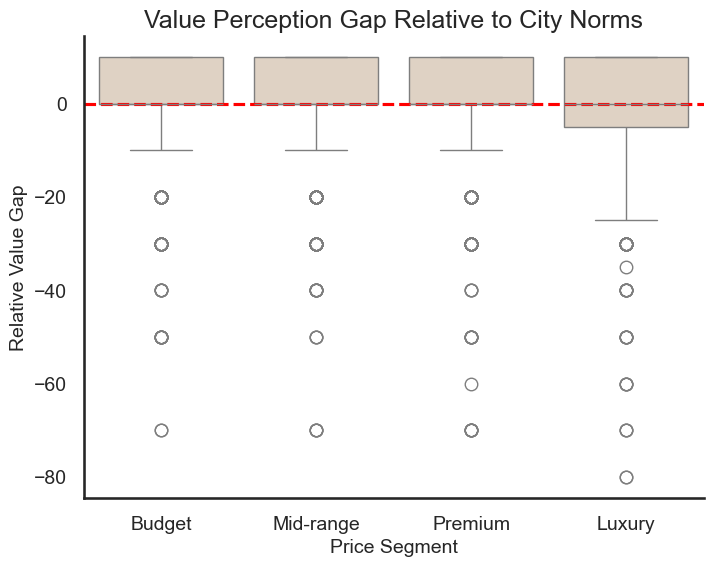

In [871]:
if 'expected_value_city' in df_filtered.columns:
    df_filtered = df_filtered.drop(columns=['expected_value_city'])

# Calculate city-adjusted expected value (median score per segment)
city_segment_median = df_filtered.groupby(['city', 'city_price_segment'])['review_scores_value'].median()

# Compute gap relative to city-segment benchmark
df_filtered = df_filtered.merge(
    city_segment_median.rename('expected_value_city'),
    left_on=['city', 'city_price_segment'],
    right_index=True
)
df_filtered['relative_value_gap'] = df_filtered['review_scores_value'] - df_filtered['expected_value_city']

sns.boxplot(
    x='city_price_segment',
    y='relative_value_gap',
    data=df_filtered,
    order=['Budget',  'Mid-range', 'Premium', 'Luxury'], color='#e4d2bf'
)
plt.axhline(0, color='red', linestyle='--')
plt.title('Value Perception Gap Relative to City Norms')
plt.xlabel('Price Segment')
plt.ylabel('Relative Value Gap')
df_filtered.to_csv('df_filtered_with_gap.csv', index=False)

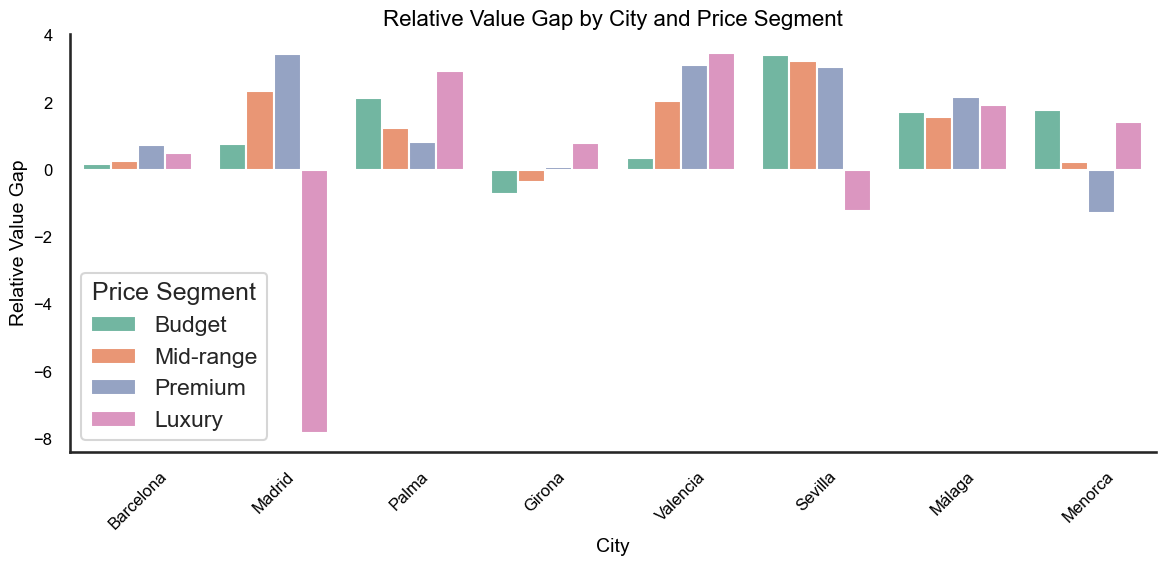

In [889]:
manual_order = [ 'Barcelona', 'Madrid', 'Palma','Girona', 'Valencia', 'Sevilla', 'Málaga',  'Menorca']

segment_order = ['Budget', 'Mid-range', 'Premium', 'Luxury']
sorted_cities = sorted(df_filtered['standardized_city'].unique())

plt.figure(figsize=(12, 6))

# Barplot
sns.barplot(
    data=df_filtered,
    x='standardized_city',
    y='relative_value_gap', order=manual_order,
    hue='city_price_segment', hue_order=segment_order,
    palette='Set2', ci=None 
)

# Remove spines (black borders)
sns.despine()  # Removes top and right spines by default

# Optional: Customize further
plt.title('Relative Value Gap by City and Price Segment', fontsize=16, color='black')
plt.xlabel('City', fontsize=14, color='black')
plt.ylabel('Relative Value Gap', fontsize=14, color='black')
plt.xticks(rotation=45, fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')
plt.legend(title='Price Segment')
plt.tight_layout()

plt.show()
